<h1><center> Final Notebook </center?</h1>
<h1><center> Winter 2023 COMP 4449 </center?</h1>
<h1><center> By: Patrick Ayers </center?</h1>

<h2><center>Loading Packages and Making Functions</center></h2>


In [239]:
# loading in needed packages
import pandas as pd
import numpy as np
import textstat
from collections import Counter
import openai
import os
import re
from dotenv import load_dotenv
import itertools
import time
import json
import statistics
from difflib import SequenceMatcher
from matplotlib.pyplot import figure
import seaborn
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from sqlalchemy import create_engine
import datetime
# Turn off warning so not clutter up code
# the warning that is turned off is for appending data from a pandas df
pd.set_option('mode.chained_assignment', None)

In [34]:
# Building functions used for plotting data
# this function was found on matplotlib website:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<h2><center> Getting information from .env file and setting globe variable </center></h2>

In [205]:
# Loading in Information from .env file
load_dotenv()
# Database connection information
USER = os.getenv("User")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
PORT = os.getenv("PORT")
DATABASE = os.getenv("DATABASE")

# Getting API key from .env file
API_KEY = os.getenv("OPENAI_KEY")
BASESTRING = "Rewrite this description but with a tone of great quality and fashionable."


<h2><center> Connecting to Database </h2></center>

In [206]:
# This datapull will grab any product data that does not have a new product discription.
DATAPULL = """SELECT ProdID,
                Vendor,
                Type,
                color,
                CONCAT(type,' in ',color,' from ',vendor')
                FROM taylorstich.productdata
                 WHERE ProdID NOT IN (SELECT DISTINCT ProdID FROM newproductdiscription;"""
DBEngine = create_engine(f'mysql+mysqlconnector://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}')
DBConnection = DBEngine.connect()
newProduct = DBConnection.execute(DATAPULL)
newProductDF = pd.DataFrame(newProduct.fetchall())

<h3><center> Building the Product description draft </center></h3>

In [182]:
# Because the database that this program use is on my personal computer I have added some temp data
# that will let the program run.
newProductDF = pd.DataFrame({'ProdID':[1],'Vendor':['Tyalor Stitch'],'Type':['Camp Sock'],'Color':['soil Marl'],'clean_body_text':['The Camp Sock in Soil Marl from Taylor Stitch']})
# Building out parameters
modelPeram = [ [.1,.5],
               # max_Tokens
               [2048],
               # feq_pen
               [1],
               # pres_pen
               [1]]
modelPeramList = (list(itertools.product(*modelPeram)))
# adding extra Columns to Dataframe
newColList = []
# Building out the column names with the format of Temp_maxTokens_feqPen_presPen
for apiPerm in range(0,len(modelPeramList)):
    newColList.append((f"{modelPeramList[apiPerm][0]}_{modelPeramList[apiPerm][1]}_" \
   f"{modelPeramList[apiPerm][2]}_{modelPeramList[apiPerm][3]}"))

# Adding blank columns to dataset
for col in newColList:
    print(col)
    newProductDF[str(col)]= ""
#newProductDF=pd.melt(newProductDF,id_vars= ['ProdID','Vendor','Type','Color','clean_body_text'] ,value_vars=newColList,var_name='model_info')
# Making a dictionary for information from the API call
output_dic_1 = {}


0.1_2048_1_1
0.5_2048_1_1


In [184]:
#Connection to open AI
openai.api_key = API_KEY
# Running the API calls for each product and model setting
for apiPerm in range(0, len(newColList)):
    # Breaking apart the column name to get the peaces for each api call
    tempPeram = newColList[apiPerm].split("_")
    print(f"Executing API call iteration {apiPerm}.")
    for prod in range(0, len(newProductDF.index)):
        print(f"Calling API on product number {prod}.")
        api_call_string = "{}{}".format(BASESTRING, newProductDF.loc[prod, 'clean_body_text'])
        response = openai.Completion.create(
            model="text-davinci-003",
            prompt=api_call_string,
            temperature=float(tempPeram[0]),
            max_tokens=int(tempPeram[1]),
            top_p=.80,
            frequency_penalty=int(tempPeram[2]),
            presence_penalty=int(tempPeram[3]),
            stop=["\"\"\""]
        )
        # adding the key for the last API call
        outputDicName = str(newColList[apiPerm]+"_"+str(newProductDF['ProdID'][prod]))
        # adding the information to output dictionary from the last API call
        output_dic_1[outputDicName] = response
        # adding the product description to a dataframe
        newProductDF.loc[prod, newColList[apiPerm]] = str(response['choices'][0]['text'])
        #print(response['choices'][0]['text'])
        # To not get an error message from calling the API to much
        time.sleep(2)

Executing API call iteration 0.
Calling API on product number 0.
Executing API call iteration 1.
Calling API on product number 0.


<h3><center> Saving Data files </center><h3>

In [ ]:
# Building a directory for output file
newDir = 'productOutput'
parentDir = 'C:/Users/patri/OneDrive/Grad_School/COMP_4449_Capstone/ChatGPT_Project_V2'
timeStamp = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
path = os.path.join(parentDir,newDir)
os.makedirs(path)
# Saving results of API calls to disk
newProductDF.to_csv(f'newProductDescription_{timeStamp}.csv')
with open(f'ProductDescriptionAPIMetaData_{timeStamp}.tet','w') as file:
    file.write(json.dumps(output_dic_1))

<h2><center> Running Sentiment and Comparison </center></h2>

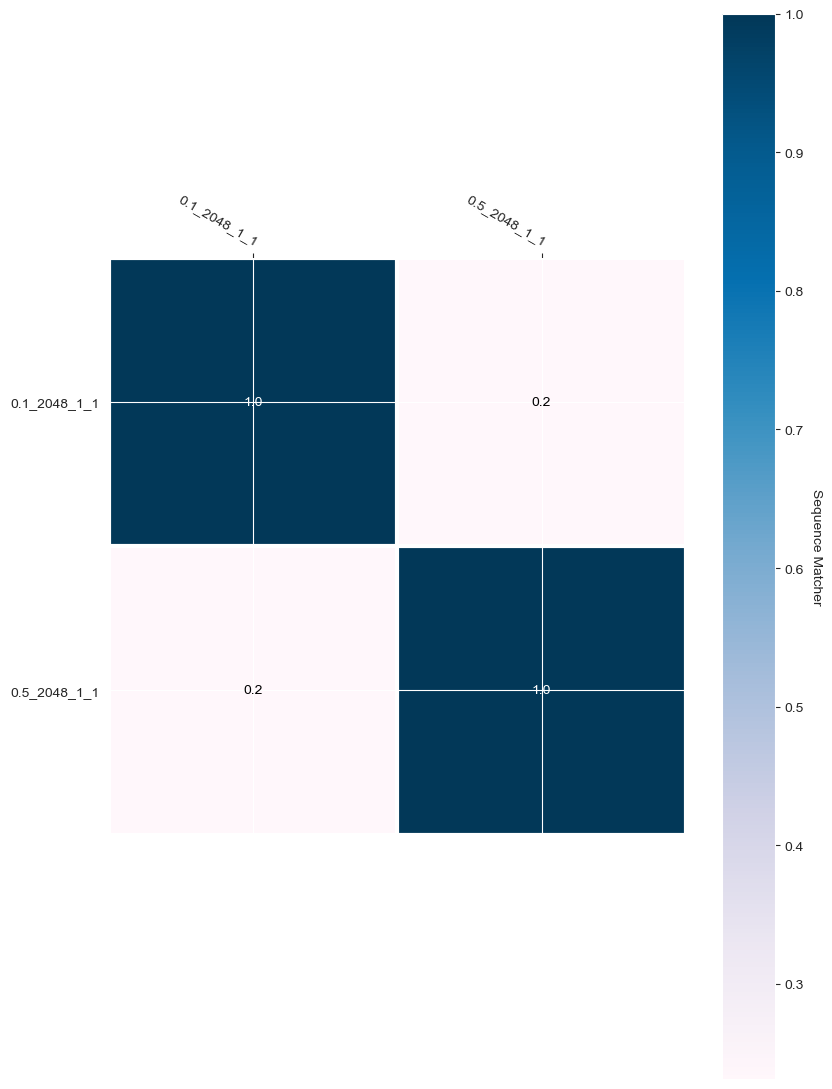

In [186]:
# checking if there is more model that needs to be tested
if len(modelPeramList) > 1:
# Building output dataframe
    SequenceMatchDF = pd.DataFrame(np.nan,index = newColList , columns = newColList)
# Iterating for each column and each row
    for col in range(0,len(newColList)):
        #print(f'Working on col number {col}')
        for row in range(0,len(newColList)):
            #print(f' Working on row number {row}')
            similarityList = []
            # Getting a senences for each model and comparing too
            for i in range(0,len(newProductDF.index)):
                stringA = newProductDF.loc[i,newColList[col]]
                #print(i)
                stringB = newProductDF.loc[i,newColList[row]]
                similarityList.append(SequenceMatcher(None,stringA,stringB).ratio())
            # averaging the difference.
            similarityMean = statistics.mean(similarityList)
            if row == col:
                SequenceMatchDF.iloc[row,col] = statistics.mean(similarityList)
            else:
                SequenceMatchDF.iloc[row,col] = statistics.mean(similarityList)
                SequenceMatchDF.iloc[col,row] = statistics.mean(similarityList)
    fig, ax = plt.subplots()
    im, cbar = heatmap(SequenceMatchDF, newColList, newColList, ax=ax, cmap="PuBu", cbarlabel="Sequence Matcher")
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    fig.set_size_inches(8.5, 11)
    fig.tight_layout()
    plt.show()


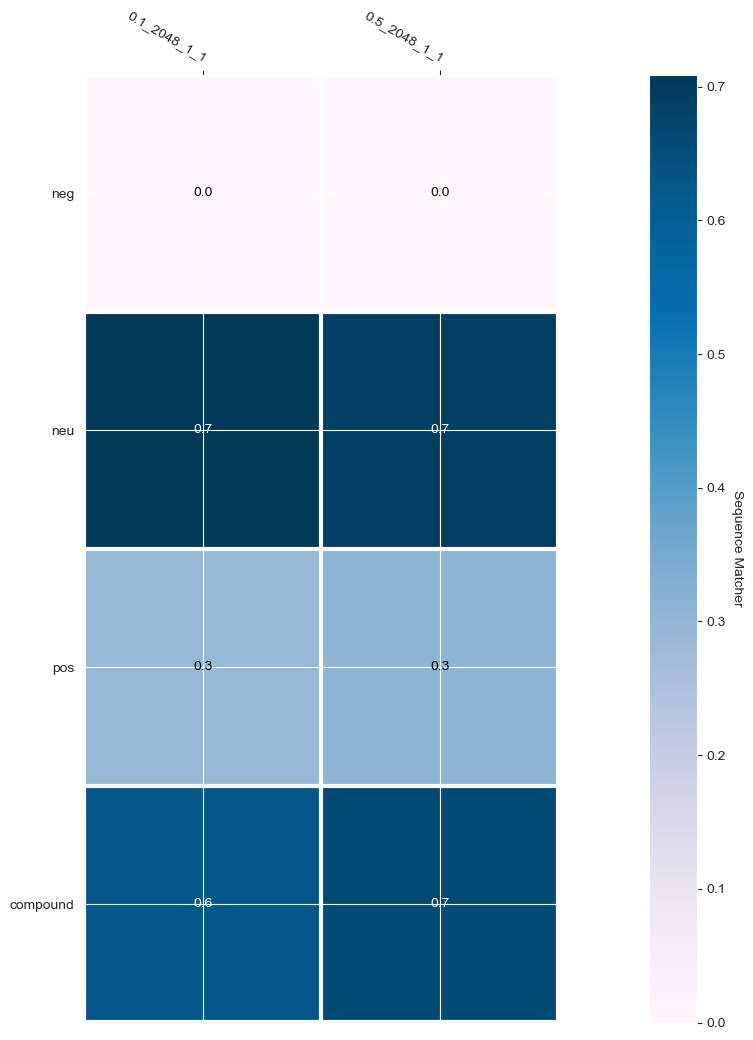

In [187]:
from nltk.sentiment import SentimentIntensityAnalyzer
# Running Sentiment Analysis

if len(modelPeramList)> 1:
    polarityScoresDF = pd.DataFrame(np.nan,index = ['neg','neu','pos','compound'] , columns = newColList)
    sia = SentimentIntensityAnalyzer()
    sia.polarity_scores(str(newProductDF.loc[:,newColList]))
    for i in range(0,len(newColList)):
        temp_dic = sia.polarity_scores(str(newProductDF.loc[:,newColList[i]]))
        polarityScoresDF.loc['neg',newColList[i]] = temp_dic['neg']
        polarityScoresDF.loc['neu',newColList[i]] = temp_dic['neu']
        polarityScoresDF.loc['pos',newColList[i]] = temp_dic['pos']
        polarityScoresDF.loc['compound',newColList[i]] = temp_dic['compound']

    # Code to make a heat map for all the data made in the statement above
    fig, ax = plt.subplots()
    im,cbar = heatmap(polarityScoresDF,['neg','neu','pos','compound'],newColList,ax=ax, cmap="PuBu", cbarlabel="Sequence Matcher")
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    plt.show()

<h2><center> Running Grammar Fix </center></h2>

In [189]:
# First we need to convert the DF from a wide format to long format
newProductDF = pd.melt(newProductDF,id_vars= ['ProdID','Vendor','Type','Color','clean_body_text'] ,value_vars=newColList,var_name='model_info',value_name='Draft_text')

In [240]:

dataKeys = list(output_dic_1.keys())
# add new columns to output dataframe
ColList = ['product_name','id', 'object', 'created', 'model', 'choices=>text', 'choices=>index'
    , 'choices=>logprobs', 'choices=>finish_reason', 'usage=>prompt_Tokens'
    , 'usage=>completion_tokens', 'usage=>total_tokens']
for ii in ColList:
    newProductDF[str(ii)]=""
# Adding all of the meta data that was gathered from the first API call
for ii in range(0,len(dataKeys)):
    newProductDF['product_name'][ii] = dataKeys[ii]
    newProductDF['id'][ii] = output_dic_1[dataKeys[ii]]['id']
    newProductDF['object'][ii] = output_dic_1[dataKeys[ii]]['object']
    newProductDF['created'][ii] = output_dic_1[dataKeys[ii]]['created']
    newProductDF['model'][ii] = output_dic_1[dataKeys[ii]]['model']
    newProductDF['choices=>text'][ii] = output_dic_1[dataKeys[ii]]['choices'][0]['text']
    newProductDF['choices=>index'][ii] = output_dic_1[dataKeys[ii]]['choices'][0]['index']
    newProductDF['choices=>logprobs'][ii] = output_dic_1[dataKeys[ii]]['choices'][0]['logprobs']
    newProductDF['choices=>finish_reason'][ii] = output_dic_1[dataKeys[ii]]['choices'][0]['finish_reason']
    newProductDF['usage=>prompt_Tokens'][ii] =output_dic_1[dataKeys[ii]]['usage']['prompt_tokens']
    newProductDF['usage=>completion_tokens'][ii] = output_dic_1[dataKeys[ii]]['usage']['completion_tokens']
    newProductDF['usage=>total_tokens'][ii] = output_dic_1[dataKeys[ii]]['usage']['total_tokens']

In [241]:
# Adding new columns to newProductDF that will be used after the grammar fixes
newProductDF['grammarObject'] = ""
newProductDF['grammartcreated']= ""
newProductDF['grammartFixedText'] = ""
newProductDF['grammarPromptTokens'] = ""
newProductDF['grammarcompletionTokens'] = ""
newProductDF['grammarTotalTokens'] = ""
newProductDF['flesch_reading_ease'] = ""
newProductDF['flesch_kincaid_grade'] = ""
newProductDF['Product_Discription_Value'] = ""

# Running the Grammar fixing process
for ii in newProductDF.index:
    # Calling openAI API to fix grammar
    tempOutPut = openai.Edit.create(
        model='text-davinci-edit-001',
        input= newProductDF['choices=>text'][ii],
        instruction='Fix grammar',
        n=1)
    # adding grammar metadata to the DF
    newProductDF['grammarObject'][ii] = tempOutPut['object']
    newProductDF['grammartcreated'][ii] = tempOutPut['created']
    newProductDF['grammartFixedText'][ii]  = tempOutPut['choices'][0]['text']
    newProductDF['grammarPromptTokens'][ii]  = tempOutPut['usage']['prompt_tokens']
    newProductDF['grammarcompletionTokens'][ii]  = tempOutPut['usage']['completion_tokens']
    newProductDF['grammarTotalTokens'][ii]  = tempOutPut['usage']['total_tokens']

    # Running the flesch_reading and flesch kincaid testr
    textstat.set_lang('en_US')
    newProductDF['flesch_reading_ease'][ii]  = textstat.flesch_reading_ease(newProductDF['grammartFixedText'][0])
    newProductDF['flesch_kincaid_grade'][ii]  = textstat.flesch_kincaid_grade(newProductDF['grammartFixedText'][0])
    # removing punquations from tokens to avoid over counting
    sampleText = newProductDF['grammartFixedText'][ii]
    res = re.sub(r'[^\w\s]','',sampleText)
    sampleTextLower = res.lower()
    tokens = nltk.word_tokenize(sampleTextLower)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word , tag in tags)

    # List of the type words that will be counted.
    wordTags = ['CC','CD','DT','EX','FW',
            'IN','JJ','JJR','JJS','LS',
            'MD','NN','NNS','NNP','NNPS',
            'PDT','POS','PRP','PRP$','RB',
            'RBR','RBS','RP','TO','UH',
            'VB','VBG','VBD','VBN','VBP',
            'VBZ','WDT','WP','WRB']
    adjTags = ['JJ','JJR','JJS']
    UDAList = ['Vendor','Type','Color']

    totalWordCount = 0
    for xx in wordTags:
        totalWordCount += counts[xx]

    # List of adjustive
    totalAdjWordCount = 0
    for xx in adjTags:
        totalAdjWordCount += counts[xx]
    #print(totalAdjWordCount)

    udaUseCount = 0
    for xx in UDAList:
        udaUseCount += sampleTextLower.count(newProductDF[xx][0].lower())

    newProductDF['Product_Discription_Value'][ii] = (len(set(tokens))/totalWordCount)*(udaUseCount/len(UDAList))*(totalAdjWordCount/totalAdjWordCount)

<h2><center> Loading data into Database </c></h2>

In [237]:
# building insert section of the query for the data that will be loaded into staging tables
for row in newProductDF.index:
    insert_stmt = ("""InSERT INTO comp_4449_final.stagenewproductdiscription
        VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s, %s,%s,%s,%s,%s,%s)""")

    # building data to be loaded
    data = (str(newProductDF['ProdID'][row]),
            str(newProductDF['productdiscriptionid'][row]),
            str(newProductDF['clean_body_text'][row]),
        str(newProductDF['model_info'][row]),
        str(newProductDF['Draft_text'][row]),
        str(newProductDF['id'][row]),
        str(newProductDF['object'][row]),
        str(newProductDF['created'][row]),
        str(newProductDF['model'][row]),
        str(newProductDF['choices=>text'][row]),
        str(newProductDF['choices=>index'][row]),
        str(0),
        str(newProductDF['choices=>finish_reason'][row]),
        str(newProductDF['usage=>prompt_Tokens'][row]),
        str(newProductDF['usage=>completion_tokens'][row]),
        str(newProductDF['usage=>total_tokens'][row]),
        str(newProductDF['grammarObject'][row]),
        str(newProductDF['grammartcreated'][row]),
        str(newProductDF['grammartFixedText'][row]),
        str(newProductDF['grammarPromptTokens'][row]),
        str(newProductDF['grammarcompletionTokens'][row]),
        str(newProductDF['grammarTotalTokens'][row]),
        str(newProductDF['flesch_reading_ease'][row]),
        str(newProductDF['flesch_kincaid_grade'][row]),
        str(newProductDF['Product_Discription_Value'][row]))
    tempid = DBEngine.execute(insert_stmt,data)
    tempid.lastrowid

<h2><center> Updating tables in the database </c></h2>

In [238]:

# after data is loaded the following SQL command will be ran to move the data into the new table
updateTableSQL = """INSERT INTO comp_4449_final.newproductdiscription
SELECT tb1.prodID,
(SELECT max(ProductDiscritonID) FROM comp_4449_final.newproductdiscription)+1,
tb1.Clean_body_text,
	tb1.model_info	,
    tb1.draft_text	,
    tb1.model_id	,
    tb1.model_object,
    tb1.model_created,
    tb1.model_type	,
    tb1.choices_text,
    tb1.choices_index,
    tb1.choices_logprobs,
    tb1.choices_finish_reason,
    tb1.usage_prompt_tokens	,
    tb1.usage_completion_tokens,
    tb1.usage_total_tokens	,
    tb1.grammar_Object	,
    tb1.crammar_created	,
    tb1.grammat_fixed_text,
    tb1.grammar_prompt_tokens,
    tb1.grammar_completion_tokens,
    tb1.grammar_total_tokens	,
    tb1.flesch_reading_ease	,
    tb1.flesch_kincaid_grade,
    tb1.product_discription_value
FROM comp_4449_final.stagenewproductdiscription as tb1
INNER JOIN (SELECT *,
			DENSE_RANK() OVER (PARTITION BY
								 prodID
								ORDER BY
								 score_avg DESC
							) score_rank
				FROM ( SELECT PRODID,
						ProductDiscritonID,
						avg(flesch_reading_ease+flesch_kincaid_grade+product_discription_Value) score_avg
						fROM comp_4449_final.stagenewproductdiscription
						GROUP BY PRODID,ProductDiscritonID)as tbnone) as tb2
	ON tb1.prodID = tb2.prodID
    and tb1.ProductDiscritonID = tb2.ProductDiscritonID
WHERE tb2.score_rank = 1;"""

tempid = DBEngine.execute(updateTableSQL)
tempid.lastrowid

0